## EMPS Training and results

In [1]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
train, test = deepSI.datasets.EMPS(split_data=True)
train.y *= 1000 #rescale to  mm
test.y *= 1000
train, val =  train.train_test_split(0.28)
dt = 0.001 #1 ms
t = np.arange(len(test_sim.y))*dt

In [4]:
load = True
if not load:
    kwargs = {'n_nodes_per_layer':30, 'n_hidden_layers': 1}
    sys = deepSI.fit_systems.SS_encoder_deriv_general(nx=2, na=20, nb=20, tau=100, f_net_kwargs=kwargs, h_net_kwargs=kwargs)
    sys.fit(train, val_sys_data=val, epochs=4000, batch_size=1024, loss_kwargs=dict(nf=200),validation_measure='sim-RMS')
    sys.save_system('models-encoder-CT-EMPS/CT-encoder-model-EMPS')
else:
    sys = deepSI.load_system('models-encoder-CT-EMPS/CT-encoder-model-EMPS')

In [5]:
test_sim = sys.apply_experiment(test)

In [7]:
RMS = test_sim.RMS(test)
print(f'RMS = {RMS}')

RMS = 4.614317967710199


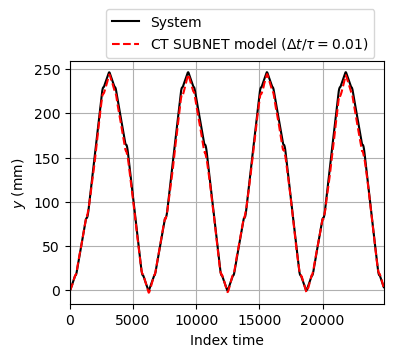

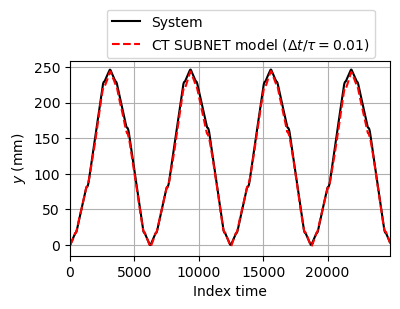

In [52]:
z = 0.9
plt.figure(figsize=(z*4.5,z*3.5))
plt.plot(test.y,'k',label='System')
plt.plot(test_sim.y,'r--',label='CT SUBNET model ($\\Delta t/\\tau = 0.01$)')
plt.grid()
plt.legend(loc=(0.1+0.015,1.0+0.015))
plt.xlim(min(t), max(t))
plt.ylabel('$y$ (mm)')
plt.xlabel('Index time')
plt.tight_layout(pad=0.9)
plt.savefig('figures-for-paper/EMPS-CT-SUBNET-sim.jpg',dpi=400)
plt.savefig('figures-for-paper/EMPS-CT-SUBNET-sim.pdf')
plt.show()


In [58]:
sys.time[-1]/60/60

10.04308890581131

## NeuralODE

In [53]:
import enum
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm

from torchdiffeq import odeint #includes exogenous inputs

class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20, udim=None):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        udim_val = 0 if udim is None else udim
        self.fc1 = nn.Linear(latent_dim + udim_val, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x, u=None):
        self.nfe += 1
        if u is not None: #append the input to the state
            x = torch.cat([x,u[:,None] if u.ndim==1 else u],dim=1)
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

def get_train_val_test(dataset):
    import deepSI
    from deepSI import System_data_list
    if dataset=='CED':
        data_full = deepSI.datasets.CED()
        train = System_data_list([data_i[:300] for data_i in data_full])
        test = System_data_list([data_i[300:] for data_i in data_full])
        val = System_data_list([t[:100] for t in test])
    elif dataset=='CCT':
        train, test = deepSI.datasets.Cascaded_Tanks()
        val, test = test[:len(test)//2], test
    elif dataset=='EMPS':
        train, test = deepSI.datasets.EMPS(split_data=True)
        train.y *= 1000 #rescale to  mm
        test.y *= 1000
        train, val =  train.train_test_split(0.28)
    return train, val, test

def get_torch_data(dataset, device=torch.device('cpu')):
    train, val, test = get_train_val_test(dataset)
    from deepSI.system_data import System_data_norm
    norm = System_data_norm() #normalization
    norm.fit(train)
    train, val, test = [norm.transform(t) for t in [train, val, test]]

    if dataset=='CCT' or dataset=='EMPS':
        samp_trajs = train.y[None,:,None]
        u_samp_trajs = train.u[None,:,None]
        orig_trajs = test.y[None,:,None]
        u_orig_trajs = test.u[None,:,None]
        val_trajs = val.y[None,:,None]
        u_val_trajs = val.u[None,:,None]

        sample_time = 4. if dataset=='CCT' else 1.
        samp_ts = np.arange(len(train.y))*sample_time

    elif dataset=='CED':
        samp_trajs = np.array([ti.y[:,None] for ti in train])
        u_samp_trajs =  np.array([ti.u for ti in train])
        orig_trajs = np.array([ti.y[:,None] for ti in test])
        u_orig_trajs = np.array([ti.u for ti in test])
        val_trajs = np.array([ti.y[:,None] for ti in val])
        u_val_trajs = np.array([ti.u[:,None] for ti in val])

        sample_time = 1/50
        samp_ts = np.arange(len(train[0]))*sample_time

    orig_trajs = torch.from_numpy(orig_trajs).float().to(device) #samples, time
    u_orig_trajs = torch.from_numpy(u_orig_trajs).float().to(device)
    samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
    u_samp_trajs = torch.from_numpy(u_samp_trajs).float().to(device)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)
    u_val_trajs = torch.from_numpy(u_val_trajs).float().to(device)
    val_trajs = torch.from_numpy(val_trajs).float().to(device)
    
    return orig_trajs, u_orig_trajs, samp_trajs, u_samp_trajs, samp_ts, \
            u_val_trajs, val_trajs, sample_time, norm

In [54]:
dataset='EMPS'
method = 'rk4' #exogenous inputs only implemented for Euler, RK4 and midpoint.
device = torch.device('cpu')
train_dir = './models-neural-ode/'
niters = 20000

#given by latent_ODE:
nhidden = 20
rnn_nhidden = 25
obs_dim = 1
noise_std = 0.1

orig_trajs, u_orig_trajs, samp_trajs, u_samp_trajs, samp_ts, u_val_trajs, val_trajs, sample_time, norm = \
        get_torch_data(dataset, device=device)

tau_1 = True

if dataset=='CCT':
    dttau = 0.032
    latent_dim = 2
    
elif dataset=='CED':
    dttau = 0.12
    latent_dim = 3
elif dataset=='EMPS':
    dttau = 0.01
    latent_dim = 2
    
tau = 1 if tau_1 else sample_time/dttau
    
samp_ts /= tau #dt /dt * dttau = dttau

has_val = True

In [56]:
for I in range(1,100):
    
    # create model
    print(f'I={I}')
    udim = 1 if u_orig_trajs.ndim==2 else u_orig_trajs.shape[-1]
    func = LatentODEfunc(latent_dim, nhidden, udim=udim).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, samp_trajs.shape[0]).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=0.01)
    loss_meter = RunningAverageMeter()

    try: #for KeyboardInterrupt stopping of iterations
        best_val = float('inf')
        for itr in tqdm(range(1, niters + 1)):
            optimizer.zero_grad()
            # backward in time to infer q(z_0)
            h = rec.initHidden().to(device)
            for t in reversed(range(samp_trajs.size(1))):
                obs = samp_trajs[:, t, :]
                out, h = rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

            # forward in time and solve ode for reconstructions
            pred_z = odeint(func, z0, samp_ts, u=u_samp_trajs, method=method).permute(1, 0, 2)
            pred_x = dec(pred_z)

            # compute loss
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0)
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item())


            if has_val and itr%1==0:

                h = rec.initHidden().to(device)
                for t in reversed(range(val_trajs.size(1))):
                    obs = val_trajs[:, t, :]
                    out, h = rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

                # forward in time and solve ode for reconstructions
                pred_z = odeint(func, z0, samp_ts[:u_val_trajs.shape[1]], u=u_val_trajs, method=method).permute(1, 0, 2)
                pred_x = dec(pred_z)
                val_trajs_p = pred_x.detach()
                RMS = torch.mean((val_trajs_p - val_trajs)**2).item()**0.5
                print('Iter: {}, running avg elbo: {:.4f} rms val {:.4f}'.format(itr, -loss_meter.avg, RMS))
                if RMS<best_val:
                    best_val = RMS
                    if train_dir is not None:
                        if tau_1:
                            ckpt_path = os.path.join(train_dir, f'ckpt-best-{dataset}-{I}-tau_1.pth')
                        else:
                            ckpt_path = os.path.join(train_dir, f'ckpt-best-{dataset}-{I}.pth')
                        torch.save({
                            'func':func,
                            'rec':rec,
                            'dec':dec,
                            'func_state_dict': func.state_dict(),
                            'rec_state_dict': rec.state_dict(),
                            'dec_state_dict': dec.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'orig_trajs': orig_trajs,
                            'samp_trajs': samp_trajs,
                            'samp_ts': samp_ts,
                        }, ckpt_path)
                        print('Stored ckpt at {} {}'.format(ckpt_path, RMS))

    except KeyboardInterrupt:
        print(f'stopped by keyboard I={I}')
        break
    if train_dir is not None:
        if tau_1:
            ckpt_path = os.path.join(train_dir, f'ckpt-last-{dataset}-{I}-tau_1.pth')
        else:
            ckpt_path = os.path.join(train_dir, f'ckpt-last-{dataset}-{I}.pth')
        torch.save({
            'func':func,
            'rec':rec,
            'dec':dec,
            'func_state_dict': func.state_dict(),
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
    print('Training complete after {} iters.'.format(itr))

I=1


  0%|          | 0/20000 [00:00<?, ?it/s]

Iter: 1, running avg elbo: nan rms val nan
Iter: 2, running avg elbo: nan rms val nan
Iter: 3, running avg elbo: nan rms val nan
stopped by keyboard I=1


## Did not converge